# Text Generation with RNNs

In this notebook we use the components developed in `modelling.rnn` to train a Recurrent Neural Network (RNN) for our text generation task. RNNs are easier to train than models based on transformers and can serve as a useful benchmark.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.rnn` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [4]:
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import rnn as rnn
from modelling import utils as utils

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [5]:
MODEL_NAME = "lstm_next_word_gen"

SIZE_EMBED = 256
SIZE_HIDDEN = 512

MAX_EPOCHS = 30
BATCH_SIZE = 256
SEQ_LEN = 100
MIN_WORD_FREQ = 2
LEARNING_RATE = 0.005

## Setup Training Data

In [6]:
datasets = data.make_sequence_datasets(seq_len=SEQ_LEN, min_freq=MIN_WORD_FREQ)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [7]:
model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)
model

NextWordPredictionRNN(
  (_embedding): Embedding(69014, 256)
  (_lstm): LSTM(256, 512, batch_first=True)
  (_linear): Linear(in_features=512, out_features=69014, bias=True)
)

Let's count how many parameters this model has.

In [8]:
print(f"{utils.count_params(model):,}")

215,234


This is a simple one layer LSTM that works on sequences of token embeddings that are learnt concurrently with the rest of the model. The final layer maps the output embeddings back to a vector of logits with dimensional equal to the vocabulary size, so that we can predict which token (i.e, category) the next word in the sequence belongs to.

## Train

In [9]:
train_losses, val_losses, best_checkpoint = rnn.train(
    model, train_dl, val_dl, MAX_EPOCHS, LEARNING_RATE
)
utils.save_model(model, name=MODEL_NAME, loss=best_checkpoint.val_loss)

epoch 6 training loss = 4.4142: 100%|██████████| 166/166 [12:01<00:00,  4.35s/it]



best model:
|-- epoch: 4
|-- validation loss: 5.2046


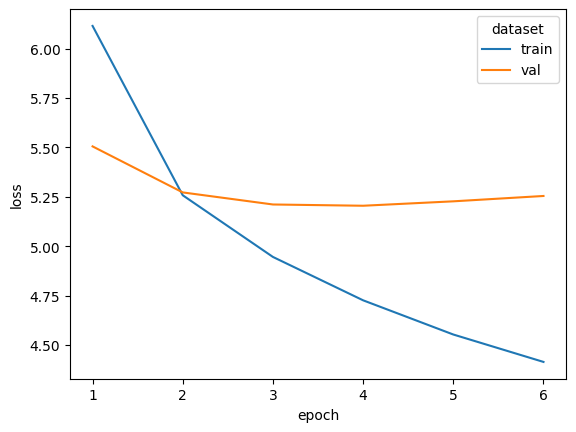

In [10]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [11]:
best_model: rnn.NextWordPredictionRNN = utils.load_model(MODEL_NAME)

loading .models/lstm_next_word_gen/trained@2023-07-22T03:41:11;loss=5_0909.pt


Then set a prompt.

In [12]:
prompt = "This is a classic horror and"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.

In [13]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "greedy", SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND a movie that has been done before. The acting is good.
The acting is good. The acting is bad. The acting is bad. The acting is bad. The acting
is bad. The acting is bad. The acting is bad. The acting is bad. The acting is bad. The
acting is bad. The acting is bad. The acting is bad. The acting is bad. The acting is
bad. The acting is bad. The acting is bad. The acting is bad. The acting...


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=5).

In [14]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "topk", SEQ_LEN, temperature=1.0, k=5
)
print(text)

==> THIS IS A CLASSIC HORROR AND I have ever seen it is worth a look. I was so
disappointed in this movie. I had to watch it on the dvd and watched this movie. I have
never seen anything of this movie. But this was a bad thing. But it was just a good film.
I think that it is a great story. It is a shame that this movie was so funny to watch
this. It was just too long and the plot itself is very good. The acting was awful and the
characters are believable...


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [15]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "sample", SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND fun time. Really I dont mind what this movie couldnt
find. Dates a dumb dvd sign through the country. Its a cult classic in its story just
fast moving science. The suspense. However even for a film I think it is not funny all
pisses children and loyalty. It has been done by the idiocy. The wrong thing youve ever
witnessed. All scenes are funny. It isnt light slow as horror comedy or comedy anyways
this wasnt a teen type character. Nothing really with this story was horrible and i...


### Benchmark

Compare all output with that from an untrained model.

In [16]:
untrained_model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)

text = rnn.generate(
    untrained_model, prompt, datasets.tokenizer, "greedy", SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND numerically unsavory aiken pyewacket nagase comparative
dave compounded surfboards seemsdestined chekhov interdiction prussic hunh kosugis
germanys sole filmsfor sedimentation albino 2036 krug zefferelli djalili baldwins chowder
strauss shutes haifa seeming 101st mrbumble grandmas noll bulgarias lenders repressed
deneuve ounce emphasise salome tracking avian mrmyagi megalopolis countries dolorous
fairview dying subtitle appointed dollar opting energized tremell cya slinging riot
seemsslow secaucus muco forgo mediation patio flogs armsin sbaraglia snowflake usurps
roadmovie slogans holy vanishes zuckers herrmann encyclopedia dorma chapas fairview whit
mergers katie motherhood ejaculation stepehn nat unremitting munched munched sceneand
jarhead skaal broadcasted pottery admonition lewbert upholding neat projectile bjork...
